In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.fft import fft
from skimage import feature
import scipy

In [36]:
df = pd.read_csv('../data/train_cursor.csv')
df['pos'] = df['cursor_position']% 10
df['line'] = (df['cursor_position']/10).astype(int)

In [37]:
# Optimize the function to calculate top N frequencies and their magnitudes for each 'id' using groupby and apply
def calculate_fft_features(group):

    group['pos'] = group['cursor_position']%30
    group['line'] = (group['cursor_position']/30).astype(int)

    # Perform Fourier Transform on 'pos'
    fft_values = fft(group['pos'])[1:]
    
    # Generate frequencies corresponding to the Fourier Transform values
    frequencies = np.fft.fftfreq(len(fft_values), 1)[1:]
    
    # Take absolute value to get magnitude
    fft_magnitude = np.abs(fft_values)
    
    # Identify indices where the frequencies are positive
    positive_indices = np.where(frequencies > 0)[0]
    
    # Filter out only positive frequencies and skip the zero frequency
    frequencies = frequencies[positive_indices]
    magnitudes = fft_magnitude[positive_indices]
    
    # Frequency Domain Features
    peak_freq = frequencies[np.argmax(magnitudes)]
    mean_freq = np.average(frequencies, weights=magnitudes)
    median_freq = frequencies[len(magnitudes) // 2]
    bandwidth = np.ptp(frequencies)
    freq_skewness = scipy.stats.skew(magnitudes)
    freq_kurtosis = scipy.stats.kurtosis(magnitudes)

    # Other Features
    total_energy = np.sum(magnitudes ** 2)
    
    # Spectral Entropy
    psd_norm = np.abs(magnitudes) / np.sum(np.abs(magnitudes))
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    
    # Spectral Flatness
    spectral_flatness = np.exp(np.mean(np.log(magnitudes + np.finfo(float).eps))) / np.mean(magnitudes)
    
    # Spectral Roll-off
    spectral_sum = np.cumsum(magnitudes)
    spectral_rolloff = frequencies[np.searchsorted(spectral_sum, 0.85 * spectral_sum[-1])]
    
    # Statistical Features
    mean_amplitude = np.mean(magnitudes)
    std_amplitude = np.std(magnitudes)
    skew_amplitude = scipy.stats.skew(magnitudes)
    kurtosis_amplitude = scipy.stats.kurtosis(magnitudes)

    features = {
        "Peak Frequency": peak_freq,
        "Mean Frequency": mean_freq,
        "Median Frequency": median_freq,
        "Bandwidth": bandwidth,
        "Frequency Skewness": freq_skewness,
        "Frequency Kurtosis": freq_kurtosis,
        "Total Energy": total_energy,
        "Spectral Entropy": spectral_entropy,
        "Spectral Flatness": spectral_flatness,
        "Spectral Roll-off": spectral_rolloff,
        "Mean Amplitude": mean_amplitude,
        "Std Amplitude": std_amplitude,
        "Skew Amplitude": skew_amplitude,
        "Kurtosis Amplitude": kurtosis_amplitude
    }
    
    return pd.Series(features)

In [38]:
# Use groupby and apply to optimize the calculation
df.groupby('id').apply(calculate_fft_features)#.reset_index()

,Peak Frequency,Mean Frequency,Median Frequency,Bandwidth,Frequency Skewness,Frequency Kurtosis,Total Energy,Spectral Entropy,Spectral Flatness,Spectral Roll-off,Mean Amplitude,Std Amplitude,Skew Amplitude,Kurtosis Amplitude
id,,,,,,,,,,,,,,
001519c8,0.096244,0.203113,0.25,0.499218,2.472239,9.214642,2.707294e+07,9.925968,0.748384,0.386933,112.063547,92.963331,2.472239,9.214642


In [31]:
image = np.array(df.loc[0]['magnitudes'])

contrast_manual = np.mean(np.abs(np.diff(image)))

# 5. Image Moments
# We'll use numpy and scipy.stats to calculate statistical moments
mean_moment_manual = np.mean(image)
variance_moment_manual = np.var(image)
skewness_moment_manual = scipy.stats.skew(image)
kurtosis_moment_manual = scipy.stats.kurtosis(image)

contrast_manual, mean_moment_manual, variance_moment_manual, skewness_moment_manual, kurtosis_moment_manual

(62.67257842009377,
 112.06354716715938,
 8642.180874527403,
 2.4722389968044074,
 9.214641848326913)

In [32]:
# idx = 0
# plt.plot(df.loc[idx]['frequencies'], df.loc[idx]['magnitudes'])

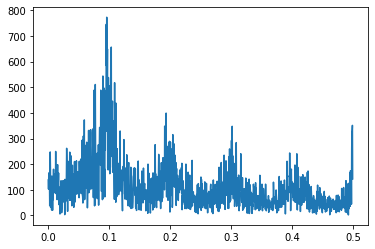

In [33]:
idx = 0
plt.plot(df.loc[idx]['frequencies'], df.loc[idx]['magnitudes'])

In [34]:
plt.hist(df['top_frequencies'].apply(lambda x: np.max(x)))

KeyError: 'top_frequencies'